# 補充 2. 用 CNN 做圖形辨識

Yann LeCun 被譽為 Deep Learning 的三巨頭之一。他的 CNN (Convolutional Neural Networks) 是讓 Neural Network 重新受到重視的主因之一。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 1. 讀入套件、準備資料

這裡我們新增一個 `Flatten` layer, 還有 `Conv2D`, `MaxPooling2D`, 使用訓練方式是 `Adadelta`, 這是參考原作的。

[Keras 範例集](https://github.com/fchollet/keras/blob/master/examples)

In [3]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adadelta
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

有些 backend 相關的資料

In [4]:
K.image_data_format()
#K是tensorflow

'channels_last'

In [6]:
(x0_train, y0_train), (x0_test, y0_test) = mnist.load_data()

In [7]:
x0_train.shape

(60000, 28, 28)

做 CNN 的時候我們可以直接把矩陣塞進去。不過一張彩色的圖通常有 R, G, B 三個矩陣, 但我們這是灰階只有一個。所以 (28, 28) 的矩陣要變成

* channels_last: (28, 28, 1)  #RGB的是(28,28,3)
* channels_first: (1, 28, 28)

注意很討厭的, 表示法是不一樣的!

In [11]:
x0_train[0]#越大的數字就是越黑

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

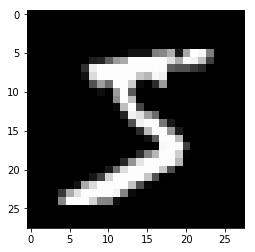

In [12]:
plt.imshow(x0_train[0],cmap="gray")

In [ ]:
x_train = x0_train.reshape(60000, 28, 28, 1)
x_test = x0_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train = x_train / 255 #normalize
x_test = x_test / 255   #normalize

In [ ]:
x_train[0] #28*28*1的一個tensor

In [49]:
y0_train[0]

5

In [ ]:
#one-hot encoding去除連續的關係
y_train = np_utils.to_categorical(y0_train, 10)
y_test = np_utils.to_categorical(y0_test, 10)

In [ ]:
y_train[0]

確定一下一個訓練輸入長什麼樣子。

In [ ]:
x_train.shape[1:]

## 2. 打造 CNN

CNN filter 一般是「越用越多」, 但要幾次 CNN, 是不是每次都要接 MaxPooling 可以自己決定!

In [19]:
model = Sequential()

注意這是 Keras 2 的寫法。我們這裡要用 10 個 3x3 的 filters。

In [20]:
model.add(Conv2D(10, (3, 3), padding='same', input_shape=(28,28,1)))#padding是外面填一層0
model.add(Activation('relu'))#可有可無，沒加上就是內積的結果

然後每 2x2 的區域做 MaxPooling。

In [21]:
model.add(MaxPooling2D(pool_size=(2, 2)))

In [22]:
model.add(Conv2D(20, (3, 3), padding='same')) #filter要越來越多
model.add(Activation('relu'))

In [23]:
model.add(MaxPooling2D(pool_size=(2, 2)))

In [24]:
model.add(Conv2D(120, (3, 3), padding='same'))
model.add(Activation('relu'))

In [25]:
model.add(MaxPooling2D(pool_size=(2, 2)))

接著要送進一般的神經網路學了, 我們用一個 hidden layer, 200 個神經元。

In [26]:
model.add(Flatten())
model.add(Dense(200))#200個神經元
model.add(Activation('relu'))

最後輸出用 softmax 處理一下。

In [27]:
model.add(Dense(10))#10個輸出
model.add(Activation('softmax'))#加起來是1，機率

In [28]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adadelta(),
              metrics=['accuracy'])
#crossentropy是機率分配用的，optimizer是優化方式

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 20)        1820      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 20)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 20)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 120)         21720     
__________

## 3. 訓練和結果

In [34]:
model.fit(x_train, y_train, batch_size=128, epochs=12)#取12次

Epoch 1/12
60000/60000 [==============================] - 61s - loss: 0.0191 - acc: 0.9939    
Epoch 2/12
60000/60000 [==============================] - 61s - loss: 0.0168 - acc: 0.9948    
Epoch 3/12
60000/60000 [==============================] - 61s - loss: 0.0138 - acc: 0.9960    
Epoch 4/12
60000/60000 [==============================] - 58s - loss: 0.0119 - acc: 0.9964    
Epoch 5/12
60000/60000 [==============================] - 54s - loss: 0.0104 - acc: 0.9969    
Epoch 6/12
60000/60000 [==============================] - 50s - loss: 0.0093 - acc: 0.9973    
Epoch 7/12
60000/60000 [==============================] - 37s - loss: 0.0081 - acc: 0.9977    
Epoch 8/12
60000/60000 [==============================] - 28s - loss: 0.0067 - acc: 0.9980    
Epoch 9/12
60000/60000 [==============================] - 14s - loss: 0.0062 - acc: 0.9983    
Epoch 10/12
60000/60000 [==============================] - 11s - loss: 0.0056 - acc: 0.9985    
Epoch 11/12
60000/60000 [========================

## 3. 看最後分數

我們把測試資料結果放 result。

In [35]:
result = model.predict_classes(x_test)

10000/10000 [==============================] - 1s     


In [36]:
result

array([7, 2, 1, ..., 4, 5, 6])

隨便看 25 個數字的結果。

In [37]:
pick = np.random.randint(1,9999, 25)

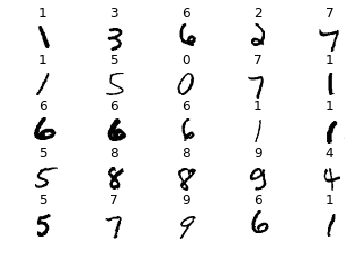

In [38]:
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x0_test[pick[i]], cmap='Greys')
    plt.title(result[pick[i]])
    plt.axis("off")

看看分數。

In [39]:
score = model.evaluate(x_test, y_test)

 9920/10000 [============================>.] - ETA: 0s

In [42]:
score

[0.031293224830735565, 0.99150000000000005]

In [40]:
loss, acc = score #testing data的成功率是沒看過的資料

In [41]:
print(acc)

0.9915


## 4. 動態展示

In [43]:
from ipywidgets import interact_manual

In [44]:
no_test=np.random.randint(0,10000)

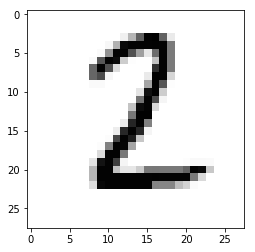

In [45]:
plt.imshow(x0_test[no_test], cmap="Greys")

In [46]:
nn_predict = result[no_test]
print('我們的神經網路說是:', nn_predict)

我們的神經網路說是: 2


In [47]:
def pickone():
    no_test=np.random.randint(0,10000)
    nn_predict = result[no_test]
    print('我們的神經網路說是:', nn_predict)
    plt.imshow(x0_test[no_test], cmap="Greys")
    plt.show()

In [48]:
interact_manual(pickone)

<function __main__.pickone>